In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//src/')

ic| str_path: ('C:\\Users\\sceac10\\OneDrive - Cardiff '
               'University\\General\\resources\\Equipment_gain_profile_TM59.xlsx')
    sheet_name: 'Normalised'
ic| sum_profile: 1.0


c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\notebooks
c:
Users
sceac10
c:\sceac10\


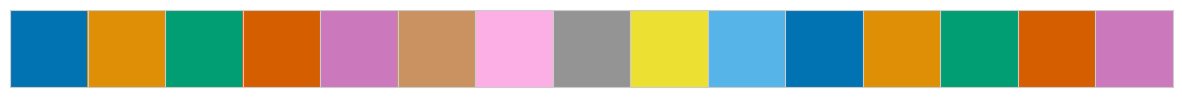

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import sys
import random
import geopandas as gpd
from common import enums, functions, schema
import main

from pathlib import Path

random.seed(42)

# blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
# sns.set_palette(sns.color_palette("Paired", 10))
# sns.set_style("white")
sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)


In [4]:
PATH_TABLES = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\communication\tables")
PATH_SAVE_FIGURES = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\communication\figures")

## Cooling demand in GB

In [5]:
residential_data = main.import_thermal_characteristics_data(
    main.PATH_GB_DATA / 'Thermal_characteristics_afterEE.csv', 2020, 2050)
residential_data.head()

c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\notebooks\..//src\common\functions.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataf[target_column].fillna("uncategorized", inplace=True)


,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
Index,,,,,,,,,,,,,,,
0,S01006506,aberdeen city,North East Scotland,detached,gas boiler,17562.500000,0.273266,115,17533.867465,175.625000,low,-5,Edinburgh,S12000033,aberdeen city
1,S01006506,aberdeen city,North East Scotland,detached,oil boiler,26400.000000,0.299051,14,19188.338395,264.000000,low,-5,Edinburgh,S12000033,aberdeen city
2,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,26475.000000,0.390676,1,25067.327542,264.750000,low,-5,Edinburgh,S12000033,aberdeen city
3,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,11138.461538,0.216864,68,13914.831788,111.384615,low,-5,Edinburgh,S12000033,aberdeen city
4,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,8822.222222,0.113292,2,7269.253731,88.222222,low,-5,Edinburgh,S12000033,aberdeen city


In [15]:
scenario_dict = {
    "high thermal capacity": ("high", '2050 high emission high thermal capacity') ,
    "medium thermal capacity": ("medium", '2050 high emission'),
    # "low thermal capacity": "low",
}

In [24]:
import icecream as ic

peak_results = []
cooling_demand_results = []

for sc_name, (thermal_capacity_level, folder) in scenario_dict.items():
  ic.ic(sc_name)
  PATH_RESULTS = Path(
      r'C:\Users\sceac10\OneDrive - Cardiff University\General\04 - Analysis'
  ) / folder
  try:
    cooling_demand = pd.read_csv(PATH_RESULTS /
                                 'cooling_demand_profiles_la.csv',
                                 index_col=0)
    lsoa_peak = pd.read_csv(PATH_RESULTS / 'cooling_peak_results_lsoa.csv',
                            index_col=[0, 1])
  except:
    filt = residential_data[schema.DwellingDataSchema.
                            THERMAL_CAPACITY_LEVEL] == thermal_capacity_level
    temp_residential_data = residential_data.loc[filt].copy()
    lsoa_peak, cooling_demand = functions.extract_cooling_demand_profiles_and_peaks(
        PATH_RESULTS, residential_data)
  lsoa_peak[schema.DwellingDataSchema.
            THERMAL_CAPACITY_LEVEL] = thermal_capacity_level
  peak_results.append(lsoa_peak)
  total_cooling_demand = cooling_demand.sum(axis=1).to_frame()
  total_cooling_demand[schema.DwellingDataSchema.
                       THERMAL_CAPACITY_LEVEL] = thermal_capacity_level
  cooling_demand_results.append(total_cooling_demand)
lsoa_peak = pd.concat(peak_results)
lsoa_peak[schema.VisualisationSchema.PEAK_COOLING] = lsoa_peak[
    schema.VisualisationSchema.PEAK_COOLING] / 1000
cooling_demand = pd.concat(cooling_demand_results)
cooling_demand = pd.pivot_table(cooling_demand, index=cooling_demand.index, columns=schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL, values=0)

ic| sc_name: 'high thermal capacity'
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission high thermal capacity/simulation/aberdeen city_S12000033/aberdeen city_S12000033_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission high thermal capacity/simulation/aberdeenshire_S12000034/aberdeenshire_S12000034_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission high thermal capacity/simulation/adur_E07000223/adur_E07000223_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission high thermal capacity/simulation/allerdale_E07000026/allerdale_E07000026_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - A

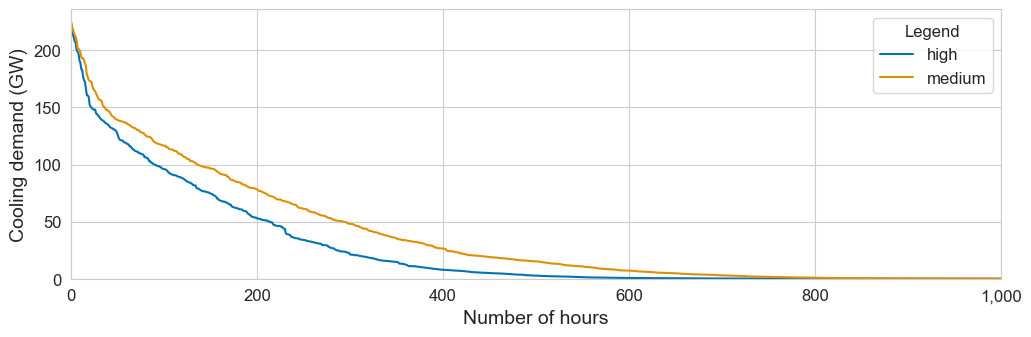

In [44]:
fig, ax = plt.subplots(figsize=figsize)
for c in cooling_demand:
  (cooling_demand[c].sort_values(ascending=False).reset_index(drop=True)/1000000).plot(
      ax=ax)
ax.margins(0, None)
ax.set_ylabel(schema.VisualisationSchema.COOLINGDEMAND_GW)
ax.set_xlabel("Number of hours")
ax.legend(title=schema.VisualisationSchema.LEGEND)
ax.set_xlim(0, 1000)
ax.set_ylim(0, None)
ax.get_xaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: "{:,.0f}".format(x)))

### Specific cooling demand by dwelling type, dwelling category and heating systems

<Axes: xlabel='Peak cooling demand (kW)', ylabel='Count'>

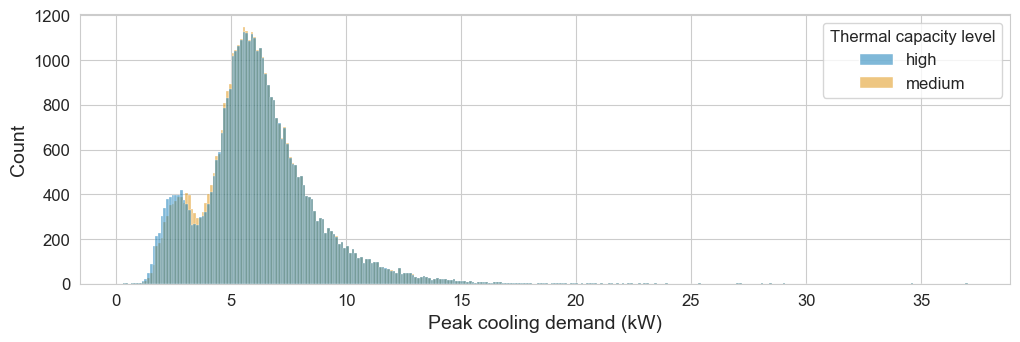

In [18]:
fig, ax = plt.subplots(figsize=figsize)
sns.histplot(data= lsoa_peak.reset_index(drop=True), x=schema.VisualisationSchema.PEAK_COOLING, hue=schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL, ax=ax)